In [1]:
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.layers import *
from shutil import copyfile
import re
import seaborn as sns
import cv2
import warnings
import torch
warnings.filterwarnings('ignore')

In [3]:
TRN_CSV_PTH = './train.csv'
TRN_DATA_PTH = './train_images'
TST_CSV_PTH = './test.csv'
TST_DATA_PTH = './test_images'
U_CSV_PTH = './unicode_translation.csv'

In [4]:
trn_df = pd.read_csv(TRN_CSV_PTH)
unicodes_df = pd.read_csv(U_CSV_PTH)

In [5]:
def create_bboxes(labels: str):
    """
    Transform label data into how fast_ai `label_from_func` likes it. That is
    an array of bounding boxes of top left, bottom right, and an array of labels for
    each box.
    [[[12,4,3,10],[14,5,4,12]], [label1], [label2]]
    """
    if('background' in labels):
        print(labels)
    dims =  [s for (i,s) in enumerate(labels.split(' ')) if i%5 != 0]
    codes = [s for (i,s) in enumerate(labels.split(' ')) if i%5 == 0]
    return [[[y1+h,x1,y1,x1+w] for [x1,y1,w,h] in np.asarray(dims,dtype=np.int64).reshape(-1,4)],codes]

In [6]:
trn_df_bb = trn_df.copy(deep=True)
trn_df_bb['labels'] = trn_df['labels'].map(create_bboxes)
trn_df_bb

,image_id,labels
0,100241706_00004_2,"[[[3518, 1231, 3465, 1364], [1721, 275, 1652, ..."
1,100241706_00005_1,"[[[2083, 1087, 2018, 1190], [1905, 1456, 1832,..."
2,100241706_00005_2,"[[[1433, 572, 1376, 697], [2148, 1551, 2080, 1..."
3,100241706_00006_1,"[[[3053, 1455, 3009, 1520], [1603, 1654, 1528,..."
4,100241706_00007_2,"[[[2982, 1201, 2949, 1228], [1575, 1196, 1539,..."
...,...,...
3600,umgy012-038,"[[[817, 876, 792, 899], [2381, 256, 2342, 350]..."
3601,umgy012-039,"[[[490, 426, 456, 456], [404, 584, 359, 666], ..."
3602,umgy012-040,"[[[362, 677, 327, 745], [506, 1424, 463, 1534]..."
3603,umgy012-041,"[[[836, 1582, 802, 1598], [2379, 597, 2337, 66..."


Reducing to one character to practice bounding box setup

In [170]:
trn_df_bb_trim = trn_df_bb.copy(deep=True)
#trn_df_bb_trim['labels'] = trn_df_bb_trim['labels'].map(lambda l: ' '.join(map(str,l[0][0])))
#trn_df_bb_trim['labels'] = trn_df_bb_trim['labels'].map(lambda l: [[l[0][0]],[l[1][0]]])
trn_df_bb_trim['image_id'] = trn_df_bb_trim['image_id'].map(lambda i: f'{i}.jpg')
trn_df_bb_trim.rename(columns={'image_id': 'name', 'labels': 'label'}, inplace=True)

In [171]:
trn_df_bb_trim

,name,label
0,100241706_00004_2.jpg,"[[[3518, 1231, 3465, 1364], [1721, 275, 1652, ..."
1,100241706_00005_1.jpg,"[[[2083, 1087, 2018, 1190], [1905, 1456, 1832,..."
2,100241706_00005_2.jpg,"[[[1433, 572, 1376, 697], [2148, 1551, 2080, 1..."
3,100241706_00006_1.jpg,"[[[3053, 1455, 3009, 1520], [1603, 1654, 1528,..."
4,100241706_00007_2.jpg,"[[[2982, 1201, 2949, 1228], [1575, 1196, 1539,..."
...,...,...
3600,umgy012-038.jpg,"[[[817, 876, 792, 899], [2381, 256, 2342, 350]..."
3601,umgy012-039.jpg,"[[[490, 426, 456, 456], [404, 584, 359, 666], ..."
3602,umgy012-040.jpg,"[[[362, 677, 327, 745], [506, 1424, 463, 1534]..."
3603,umgy012-041.jpg,"[[[836, 1582, 802, 1598], [2379, 597, 2337, 66..."


In [196]:
ocl = ObjectItemList.from_df(trn_df_bb_trim, path=TRN_DATA_PTH) \
                        .split_none() \
                        .label_from_df() \
                        .transform([], size=224) \
                        .databunch(bs=2, collate_fn=bb_pad_collate)

In [197]:
ocl

ImageDataBunch;

Train: LabelList (3605 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (3874, 2404),ImageBBox (3874, 2392),ImageBBox (3874, 2416),ImageBBox (3886, 2362),ImageBBox (3868, 2392)
Path: train_images;

Valid: LabelList (0 items)
x: ObjectItemList

y: ObjectCategoryList

Path: train_images;

Test: None

In [198]:
ocl.y.c

4213

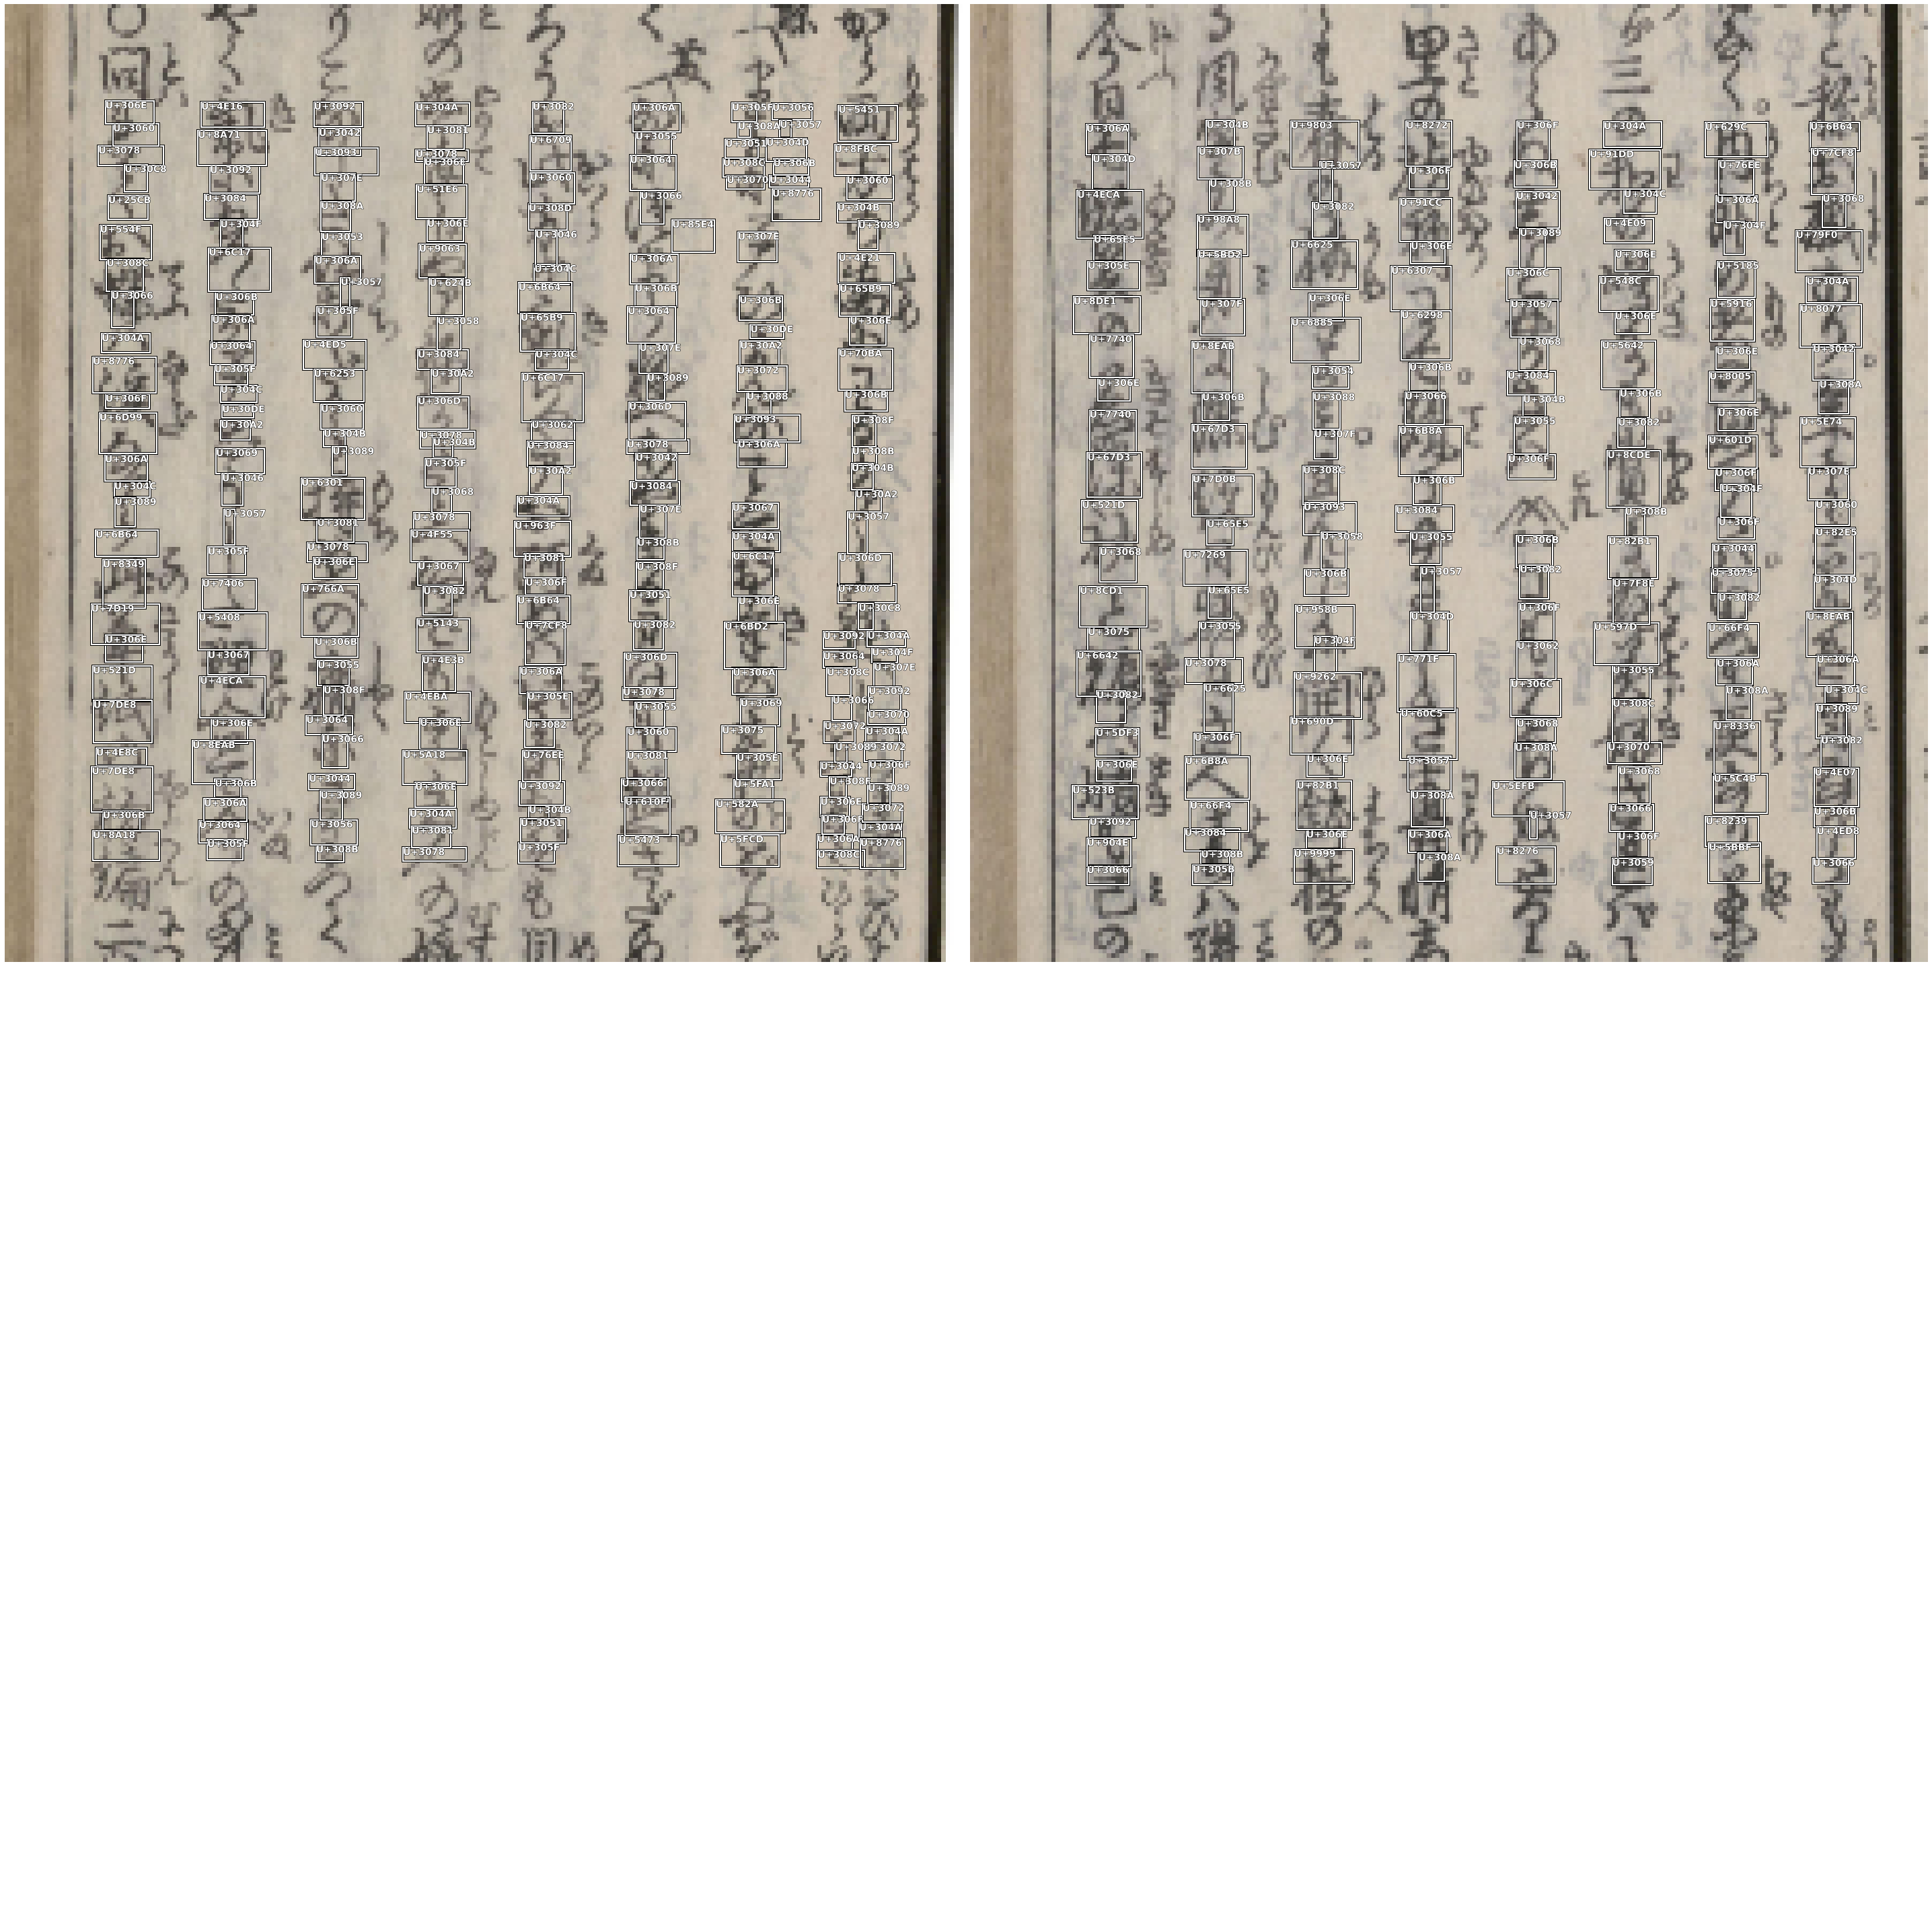

In [202]:
ocl.show_batch(figsize=(40,40))